<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [6]:
import os
import gc
import numpy as np
import pandas as pd
from src.util import *
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from time import time
import datetime
from sklearn.model_selection import TimeSeriesSplit

In [2]:
%%time
train_identity = pd.read_csv("data/train_identity.csv", )
train_transaction = pd.read_csv("data/train_transaction.csv", )
test_identity = pd.read_csv("data/test_identity.csv", )
test_transaction = pd.read_csv("data/test_transaction.csv",)

Wall time: 1min


In [3]:
train_merge = train_transaction.merge(train_identity, how='left')
test_merge = test_transaction.merge(test_identity, how='left')
del train_transaction, train_identity, test_transaction, test_identity
gc.collect()

train_merge = reduce_mem_usage(train_merge)
test_merge = reduce_mem_usage(test_merge)

print(f"Merged training set shape: {train_merge.shape}")
print(f"Merged testing set shape: {test_merge.shape}")

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)
Merged training set shape: (590540, 434)
Merged testing set shape: (506691, 433)


In [10]:
for col in train_merge.columns:
    if train_merge[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train_merge[col].values) + list(test_merge[col].values))
        train_merge[col] = le.transform(list(train_merge[col].values))
        test_merge[col] = le.transform(list(test_merge[col].values))

In [11]:
X = train_merge.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train_merge.sort_values('TransactionDT')['isFraud']
test = test_merge.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [12]:
model = lgb.LGBMClassifier(random_state=50)
hyperparameters = model.get_params()
hyperparameters['metric'] = 'auc'
hyperparameters

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 50,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc'}

In [13]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

train_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print(f"Training on fold {fold + 1}")
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(hyperparameters, trn_data, 10000, valid_sets=[trn_data, val_data],
                    verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold + 1}'] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    fold_end_time = datetime.timedelta(seconds=time() - start_time)
    
    print(f'Fold {fold + 1} finished in {str(fold_end_time)}')
print('-' * 30)
print('Train finished')
print(f'Mean AUC: {np.mean(aucs)}')
print('-'*30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.940339	valid_1's auc: 0.869141
Fold 1 finished in 0:00:07.927110
Training on fold 2
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.924098	valid_1's auc: 0.878102
Fold 2 finished in 0:00:13.473009
Training on fold 3
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.917614	valid_1's auc: 0.866076
Fold 3 finished in 0:00:18.270074
Training on fold 4
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.911015	valid_1's auc: 0.882175
Fold 4 finished in 0:00:23.000760
Training on fold 5
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteratio

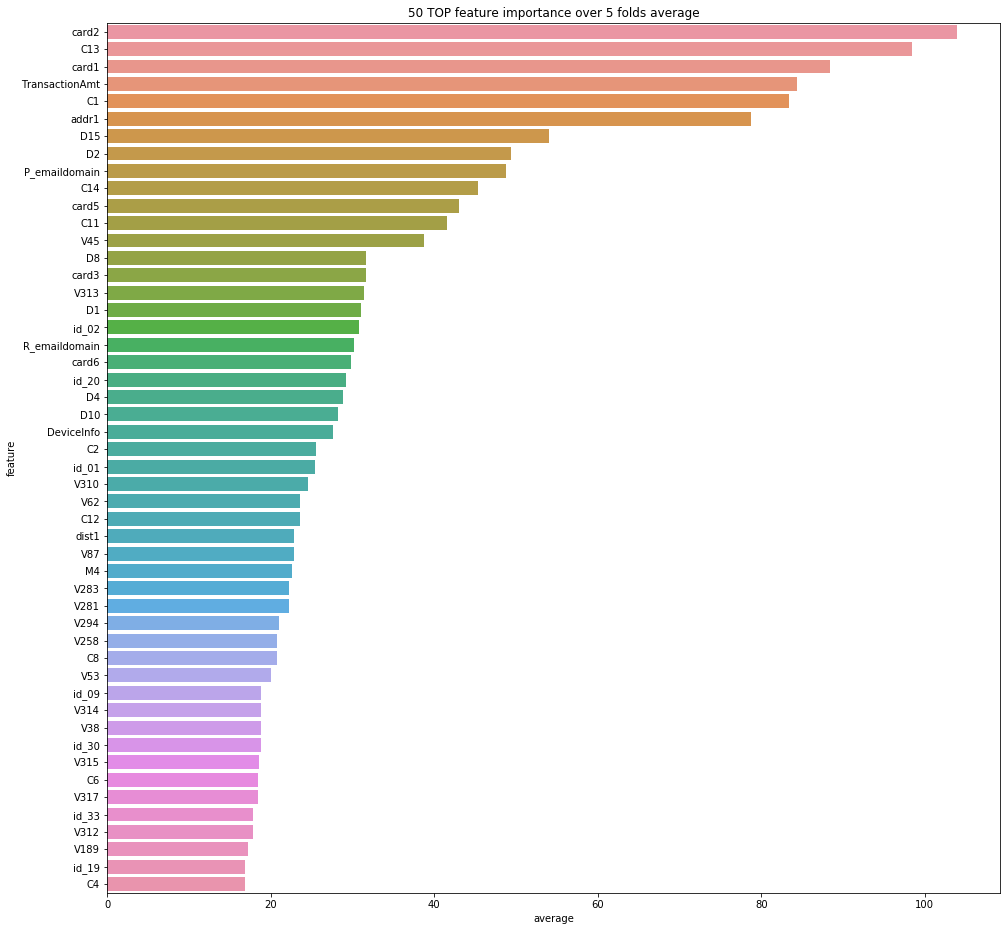

In [15]:
feature_importances['average'] = feature_importances[[f'fold_{fold + 1}' for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title(f'50 TOP feature importance over {folds.n_splits} folds average');

In [22]:
list(feature_importances.sort_values(by='average', ascending=False)['feature'].values[:50])

['card2',
 'C13',
 'card1',
 'TransactionAmt',
 'C1',
 'addr1',
 'D15',
 'D2',
 'P_emaildomain',
 'C14',
 'card5',
 'C11',
 'V45',
 'D8',
 'card3',
 'V313',
 'D1',
 'id_02',
 'R_emaildomain',
 'card6',
 'id_20',
 'D4',
 'D10',
 'DeviceInfo',
 'C2',
 'id_01',
 'V310',
 'V62',
 'C12',
 'dist1',
 'V87',
 'M4',
 'V283',
 'V281',
 'V294',
 'V258',
 'C8',
 'V53',
 'id_09',
 'V314',
 'V38',
 'id_30',
 'V315',
 'C6',
 'V317',
 'id_33',
 'V312',
 'V189',
 'id_19',
 'C4']